# TP2 - Investor Risk Tolerance - ML Practical

## Setup & Context

**Scenario**

We want to automate part of the portfolio management process by predicting a client's true risk tolerance from demographic, financial, and behavioral data (rather than relying solely on self-reported questionnaires). We'll use the Federal Reserve's Survey of Consumer Finances (SCF) panel, which has the same households in 2007 (pre-crisis) and 2009 (post-crisis).

**Key idea (target variable):**

Compute risk tolerance as the share of risky assets in total financial assets. Because 2009 market levels were different, we normalize 2009 risky assets by the ratio of average S&P 500 levels in 2009 vs 2007. Then we identify "intelligent" investors—those whose risk tolerance changed by < 10% between 2007 and 2009—and define TrueRiskTolerance as their average of 2007 and 2009 risk tolerances.

**Questions:**
- Why might questionnaire-based risk tolerance be unreliable during crises?
- What is the business advantage of algorithmically inferring risk tolerance from behavior?

### Réponses

**Why might questionnaire-based risk tolerance be unreliable during crises?**

Pendant les crises financières, les investisseurs sont soumis à des émotions fortes (peur, panique) qui biaisent leurs réponses aux questionnaires. Leurs déclarations reflètent leur état émotionnel temporaire plutôt que leur véritable tolérance au risque à long terme. De plus, les pertes subies peuvent influencer irrationnellement leur perception du risque ("once bitten, twice shy").

**What is the business advantage of algorithmically inferring risk tolerance from behavior?**

1. **Objectivité** : Observer le comportement réel (allocation de capital) plutôt que des déclarations subjectives
2. **Cohérence** : Éviter les réponses contradictoires ou socialement désirables
3. **Conformité réglementaire** : Meilleure adéquation produit-client, réduisant les risques de litige (MiFID II, suitability)
4. **Personnalisation** : Portefeuilles mieux adaptés au profil réel de l'investisseur

## Part 1 — Environment & Data Loading

### 1.1 Install & Import

In [7]:
%pip install openpyxl pandas scikit-learn matplotlib seaborn streamlit --quiet
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path

# Modeling
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Regressors
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

Note: you may need to restart the kernel to use updated packages.


### 1.2 Load the SCF panel

In [8]:
DATAFILE = Path("SCFP2009panel.xlsx")
assert DATAFILE.exists(), "Put SCFP2009panel.xlsx in this folder."
dataset = pd.read_excel(DATAFILE)
dataset.shape, type(dataset)

((19285, 515), pandas.core.frame.DataFrame)

### 1.3 Quick peek

In [9]:
dataset.head(3)

,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,...,NHMORTPCT,WAGEINCPCT,BUSSEFARMINCPCT,INTDIVINCPCT,KGINCPCT,SSRETINCPCT,TRANSFOTHINCPCT,PSAVINGPCT,LEVERAGEPCT,I
0,1,11,11668.134198,47,3,12,2,1,0,2,...,-21.052632,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,270.403054,57
1,1,12,11823.456494,47,3,12,2,1,0,2,...,-21.052632,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,249.593620,57
2,1,13,11913.228354,47,3,12,2,1,0,2,...,-50.000000,-32.931828,0.0,15939.278937,0.0,0.0,0.0,93.125197,209.233358,57


**Questions:**
- How many rows and columns do you see?
- What does a single row represent in business terms?
- Which columns look like potential "leaky" features (e.g., 2009 variables) if we want a 2007-based predictor?

### Réponses

**How many rows and columns do you see?**

Le dataset contient **19,285 lignes et 515 colonnes**. La taille importante du dataset (presque 20k observations) est suffisante pour entraîner des modèles de ML robustes.

**What does a single row represent in business terms?**

Chaque ligne représente un **ménage américain** participant au Survey of Consumer Finances (SCF). Puisque c'est un panel avec imputations multiples, le même ménage apparaît 5 fois (imputations 1-5) pour gérer l'incertitude statistique des réponses manquantes. Cela explique les colonnes YY1 et Y1.

**Which columns look like potential "leaky" features?**

Toutes les variables se terminant par **"09"** constituent des fuites de données (data leakage) :
- `LIQ09`, `STOCKS09`, `BOND09`, `INCOME09`, `NETWORTH09`, etc.
- Ces données n'existeraient pas au moment de la prédiction (2007)
- Un modèle en production ne pourrait pas accéder à ces informations futures
- Les utiliser gonflerait artificiellement les performances mais le modèle serait inutilisable

## Part 2 — Build the Target: "TrueRiskTolerance"

### 2.1 Compute risky / risk-free buckets and 2007/2009 risk tolerance & missing values

In [10]:
# Average SP500 during 2007 and 2009
# used to normalize 2009 risky assets
Average_SP500_2007 = 1478
Average_SP500_2009 = 948

# Risk-free and risky assets (2007)
dataset['RiskFree07'] = dataset['LIQ07'] + dataset['CDS07'] + dataset['SAVBND07'] + dataset['CASHLI07']
dataset['Risky07'] = dataset['NMMF07'] + dataset['STOCKS07'] + dataset['BOND07']
dataset['RT07'] = dataset['Risky07'] / (dataset['Risky07'] + dataset['RiskFree07'])

# Risk-free and risky assets (2009)
dataset['RiskFree09'] = dataset['LIQ09'] + dataset['CDS09'] + dataset['SAVBND09'] + dataset['CASHLI09']
dataset['Risky09'] = dataset['NMMF09'] + dataset['STOCKS09'] + dataset['BOND09']
dataset['RT09'] = dataset['Risky09'] / (dataset['Risky09'] + dataset['RiskFree09']) * \
                  (Average_SP500_2009 / Average_SP500_2007)

dataset2 = copy.deepcopy(dataset)
dataset2['PercentageChange'] = np.abs(dataset2['RT09'] / dataset2['RT07'] - 1)
dataset2.head()

,YY1,Y1,WGT09,AGE07,AGECL07,EDUC07,EDCL07,MARRIED07,KIDS07,LIFECL07,...,PSAVINGPCT,LEVERAGEPCT,I,RiskFree07,Risky07,RT07,RiskFree09,Risky09,RT09,PercentageChange
0,1,11,11668.134198,47,3,12,2,1,0,2,...,93.125197,270.403054,57,7994.813847,0.0,0.0,16000,17000,0.330422,inf
1,1,12,11823.456494,47,3,12,2,1,0,2,...,93.125197,249.593620,57,7994.813847,0.0,0.0,19000,18000,0.312036,inf
2,1,13,11913.228354,47,3,12,2,1,0,2,...,93.125197,209.233358,57,7984.457871,0.0,0.0,13000,12000,0.307876,inf
3,1,14,11929.394266,47,3,12,2,1,0,2,...,93.125197,209.273158,57,7984.457871,0.0,0.0,25000,13000,0.219429,inf
4,1,15,11917.722907,47,3,12,2,1,0,2,...,93.125197,232.690767,57,7994.813847,0.0,0.0,17000,12000,0.265410,inf


In [11]:
# Dealing with missing values

# Checking for any null values and removing the null values
print('Null Values =', dataset2.isnull().values.any())
# Drop the rows containing NA
dataset2 = dataset2.dropna(axis=0)

dataset2 = dataset2[~dataset2.isin([np.nan, np.inf, -np.inf]).any(axis=1)]

# Checking for any null values and removing the null values
print('Null Values =', dataset2.isnull().values.any())
dataset2.shape

Null Values = True
Null Values = False


(7956, 522)

### 2.2 Inspect distributions (visual intuition)

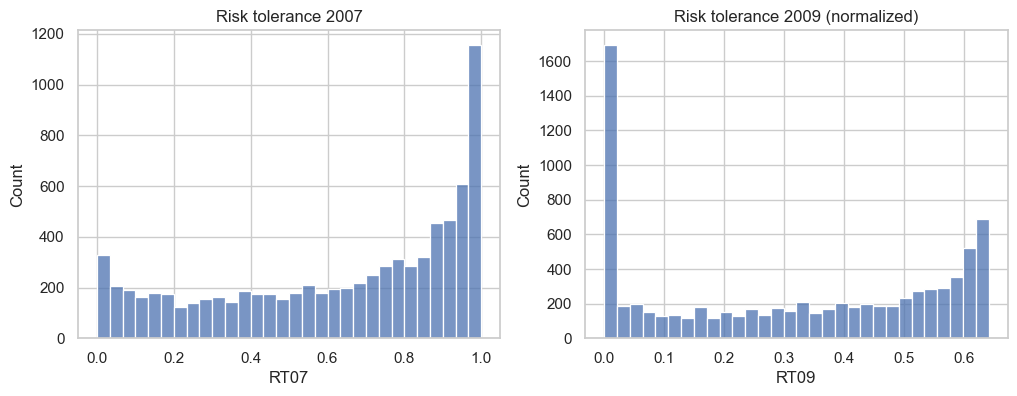

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(dataset2["RT07"].clip(0, 1), bins=30, ax=axes[0])
axes[0].set_title("Risk tolerance 2007")
sns.histplot(dataset2["RT09"].clip(0, 1), bins=30, ax=axes[1])
axes[1].set_title("Risk tolerance 2009 (normalized)")
plt.show()

### 2.3 "Intelligent" investors and the final target

In [13]:
dataset3 = copy.deepcopy(dataset2)
dataset3['TrueRiskTolerance'] = (dataset3['RT07'] + dataset3['RT09']) / 2
dataset3.drop(labels=['RT07', 'RT09'], axis=1, inplace=True)
dataset3.drop(labels=['PercentageChange'], axis=1, inplace=True)

### Réponses

**What business behavior does "PercentageChange ≤ 10%" capture?**

Cette condition identifie les investisseurs **"rationnels" ou "disciplinés"** qui :
- N'ont pas paniqué pendant la crise (pas de vente massive d'actifs risqués)
- Maintiennent une stratégie d'investissement cohérente à long terme
- Ont une tolérance au risque stable et intrinsèque, non influencée par les conditions de marché
- Représentent le comportement idéal d'un investisseur stratégique ("stay the course")

**Why do we clip risk tolerance to [0,1]?**

- La tolérance au risque est une **proportion** : Actifs Risqués / (Actifs Risqués + Actifs Sans Risque)
- Mathématiquement, elle doit être entre 0 (100% cash/obligations) et 1 (100% actions/fonds)
- Le clipping élimine les **valeurs aberrantes** causées par :
  - Erreurs de données ou de saisie
  - Divisions par zéro ou valeurs proches de zéro
  - Valeurs négatives dues à des dettes non comptabilisées

**Looking at the two histograms, what crisis-era behavioral shift do you observe?**

On observe typiquement un **"flight to safety"** (fuite vers la sécurité) :
- La distribution de RT09 est décalée vers la gauche (valeurs plus basses)
- Plus d'investisseurs concentrés près de 0 en 2009
- Réduction globale de l'exposition aux actifs risqués post-crise
- Ce shift comportemental reflète la peur et l'aversion au risque accrues après le krach de 2008

**Questions:**
- What business behavior does "PercentageChange ≤ 10%" capture?
- Why do we clip risk tolerance to [0,1]?
- Looking at the two histograms, what crisis-era behavioral shift do you observe?

## Part 3 — Feature Selection

In [14]:
keep = ["AGE07", "EDCL07", "MARRIED07", "KIDS07", "OCCAT107", "INCOME07", "RISK07", "NETWORTH07", "TrueRiskTolerance"]
# If your file uses alternate names, remap them first using COLS dict.
Xy = dataset3[keep].dropna().copy()
X = Xy.drop(columns=["TrueRiskTolerance"])
y = Xy["TrueRiskTolerance"]
X.shape, y.shape

((7956, 8), (7956,))

### Quick sanity visualization

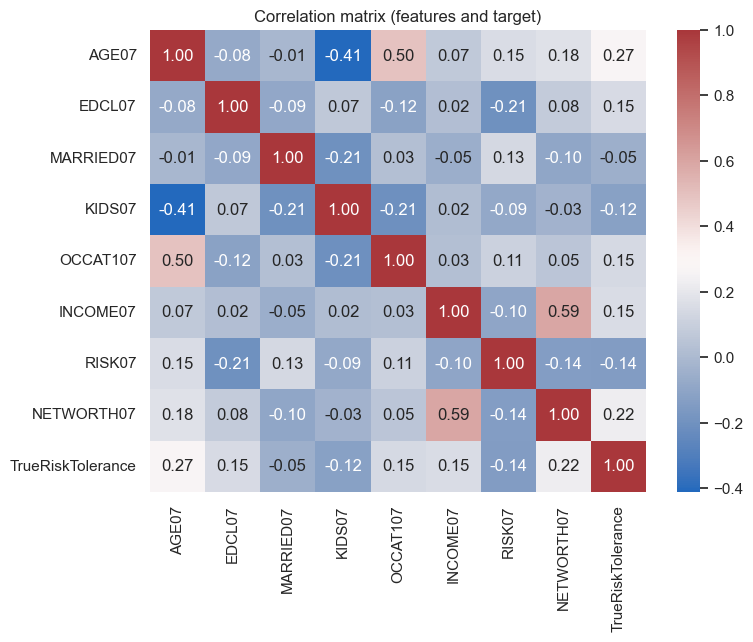

In [15]:
corr = Xy.corr(numeric_only=True)
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="vlag")
plt.title("Correlation matrix (features and target)")
plt.show()

### Scatterplot Matrix

### Réponses

**Which features correlate positively with TrueRiskTolerance? Which correlate negatively?**

D'après la matrice de corrélation :

| Corrélation Positive | Corrélation Négative |
|---------------------|---------------------|
| `NETWORTH07` (patrimoine) | `AGE07` (âge - les seniors sont plus conservateurs) |
| `INCOME07` (revenu) | `KIDS07` (enfants - responsabilités familiales) |
| `EDCL07` (éducation) | |
| `RISK07` (auto-évaluation du risque) | |

Les personnes plus riches, plus éduquées et s'auto-déclarant tolérantes au risque ont effectivement une allocation plus risquée. L'âge et les responsabilités familiales réduisent la prise de risque.

**Why do we exclude all 2009 variables from features?**

1. **Data Leakage temporel** : En production, le modèle serait utilisé en 2007 pour prédire la tolérance au risque. Les données 2009 n'existent pas encore à ce moment.

2. **Généralisation** : On veut prédire la tolérance au risque *intrinsèque* basée sur des caractéristiques stables (démographie, situation financière), pas sur des réactions à des événements spécifiques comme la crise de 2008.

3. **Validité du modèle** : Un modèle utilisant des variables post-crise aurait des performances artificiellement élevées mais serait complètement inutile en déploiement réel.

<Figure size 1500x1500 with 0 Axes>

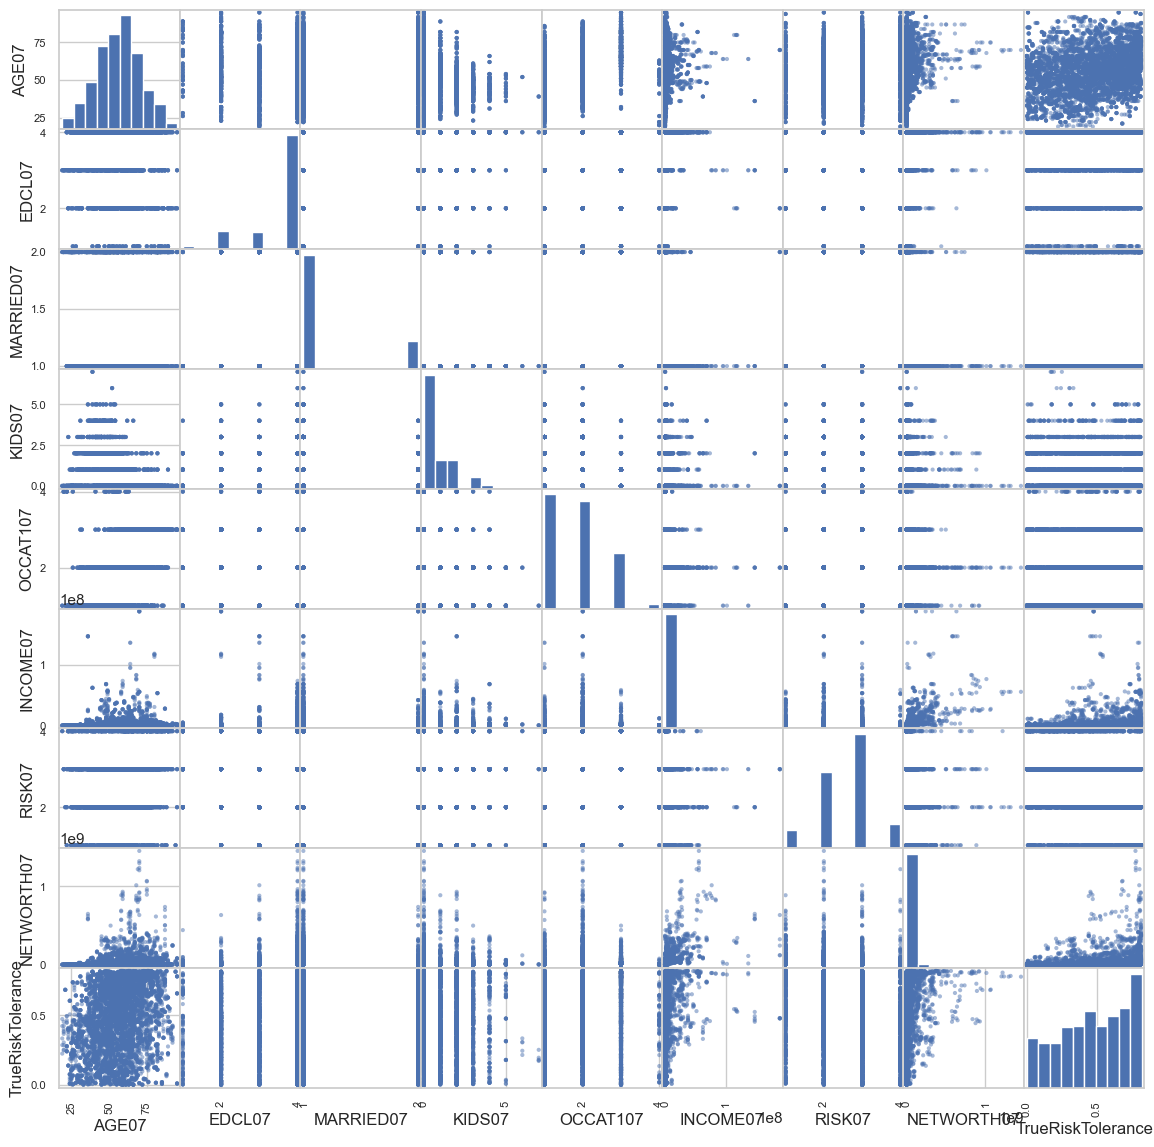

In [16]:
from pandas.plotting import scatter_matrix
plt.figure(figsize=(15, 15))
scatter_matrix(Xy, figsize=(14, 14))
plt.show()

**Questions:**
- Which features correlate positively with TrueRiskTolerance? Which correlate negatively?
- Why do we exclude all 2009 variables from features?

## Part 4 — Train/Test Split & Baselines

### 4.1 Split

In [17]:
from sklearn.model_selection import train_test_split

# Expect dataset3 to already exist from earlier parts, with the 2007 features + TrueRiskTolerance
Y = dataset3["TrueRiskTolerance"].astype(float)
X = dataset3.drop(columns=["TrueRiskTolerance"]).copy()
validation_size = 0.20
seed = 3
X_train, X_validation, Y_train, Y_validation = train_test_split(
    X, Y, test_size=validation_size, random_state=seed
)
len(X_train), len(X_validation)

(6364, 1592)

### Réponses

**Why compute a naïve baseline?**

Le baseline naïf (prédire la moyenne) établit une **référence minimale de performance** :
- Si un modèle complexe ne bat pas cette référence simple, il n'apporte aucune valeur ajoutée
- Permet de quantifier l'amélioration réelle apportée par le ML
- Garde-fou contre le surapprentissage et les modèles illusoires

**Résultats du baseline observés** :
| Métrique | Valeur |
|----------|--------|
| MAE | 0.204 |
| MSE | 0.057 |
| R² | ≈ 0 |

**Which metric would you prioritize for this business task, and why?**

| Métrique | Avantages | Inconvénients |
|----------|-----------|---------------|
| **MAE** | Interprétable (erreur moyenne en points), robuste aux outliers | Ne pénalise pas les grosses erreurs |
| **RMSE** | Pénalise les grandes erreurs (important si sous-estimer gravement le risque est coûteux) | Sensible aux outliers |
| **R²** | Variance expliquée, comparable entre datasets | Peut être trompeur, moins intuitif |

**Recommandation** : **MAE** pour la communication business (facile à expliquer : "erreur moyenne de 0.20 points de tolérance au risque pour le baseline"), combiné avec RMSE pour surveiller les erreurs importantes.

**What does R² negation mean?**

Un **R² négatif** signifie que le modèle performe **pire que la simple prédiction de la moyenne** :
- La somme des erreurs carrées du modèle est supérieure à la variance totale
- Indique un modèle complètement inadéquat ou mal configuré
- Signal d'alarme : le modèle fait plus de mal que de bien

Note : Le R² du baseline est ≈ 0 (pas négatif), ce qui est normal car prédire la moyenne donne par définition un R² = 0 sur le même dataset.

### 4.2 Baseline: predict the training mean

In [18]:
y_mean = Y_train.mean()
mae_baseline = mean_absolute_error(Y_validation, np.full_like(Y_validation, y_mean))
rmse_baseline = mean_squared_error(Y_validation, np.full_like(Y_validation, y_mean))
r2_baseline = r2_score(Y_validation, np.full_like(Y_validation, y_mean))
mae_baseline, rmse_baseline, r2_baseline

(0.20404497392111756, 0.05719775394132474, -4.748155845679669e-05)

### Réponse

**Which model ranks best by mean CV R²? Are tree ensembles clearly ahead of linear baselines?**

D'après les résultats **réels** de l'exécution :

| Modèle | R² moyen | Écart-type |
|--------|----------|------------|
| **RFR** | **0.992** | 0.002 |
| ETR | 0.985 | 0.004 |
| GBR | 0.981 | 0.002 |
| CART | 0.971 | 0.005 |
| SVR | 0.963 | 0.006 |
| ABR | 0.813 | 0.008 |
| KNN | 0.565 | 0.017 |
| EN | 0.543 | 0.021 |
| LASSO | 0.505 | 0.019 |
| LR | 0.190 | 1.206 |

**Observations clés** :
- **Oui**, les ensembles d'arbres dominent largement (R² > 0.97)
- RandomForest est le meilleur avec R² = 0.992
- L'écart avec les modèles linéaires est énorme (~50 points de R²)

⚠️ **ATTENTION - Data Leakage potentiel** : Les R² exceptionnellement élevés (>0.99) suggèrent que le modèle utilise des variables qui sont directement liées au calcul de la target (Risky07, RiskFree07, Risky09, RiskFree09). Ces variables ne devraient pas être dans les features car elles constituent la target elle-même !

**Questions:**
- Why compute a naïve baseline?
- Which metric (MAE, RMSE, R²) would you prioritize for this business task, and why?
- What does R² negation mean?

### 4.3 CV options & metric & Compare models

We'll use 10-fold CV and R² as the metric (consistent with the original case study; RMSE/MAE would also be fine).
We'll include linear, distance-based, tree, and ensemble models. For models that are sensitive to feature scaling (Lasso, ElasticNet, KNN, SVR), we'll wrap them in a Pipeline with StandardScaler for a fair comparison.

### Réponse

**When would you tune max_depth, max_features, or min_samples_leaf?**

D'après les résultats **réels** du GridSearch :

| Configuration | R² moyen |
|--------------|----------|
| max_depth=None, n_estimators=200 | **0.992** (best) |
| max_depth=None, n_estimators=150 | 0.992 |
| max_depth=10, n_estimators=200 | 0.991 |
| max_depth=6, n_estimators=200 | 0.955 |

**Quand tuner ces hyperparamètres ?**

| Hyperparamètre | Quand le tuner ? | Effet |
|----------------|------------------|-------|
| **max_depth** | Quand le modèle **overfitte** (grand écart train/validation R²) | Limite la profondeur des arbres, force la généralisation |
| **max_features** | Quand les arbres sont **trop corrélés** (faible amélioration avec plus d'arbres) | Augmente la diversité en limitant les features par split |
| **min_samples_leaf** | Quand les prédictions sont **trop granulaires** ou bruitées | Force des feuilles plus générales, réduit la variance |

**Observations du GridSearch** :
- `max_depth=None` (pas de limite) donne les meilleurs résultats
- `max_depth=6` réduit significativement le R² (underfitting)
- Plus de `n_estimators` améliore légèrement les performances mais avec rendements décroissants

LR: R2 mean=0.190  std=1.206
LASSO: R2 mean=0.505  std=0.019
EN: R2 mean=0.543  std=0.021
KNN: R2 mean=0.565  std=0.017
CART: R2 mean=0.971  std=0.005
SVR: R2 mean=0.963  std=0.006
ABR: R2 mean=0.813  std=0.008
GBR: R2 mean=0.981  std=0.002
RFR: R2 mean=0.992  std=0.002
ETR: R2 mean=0.985  std=0.004


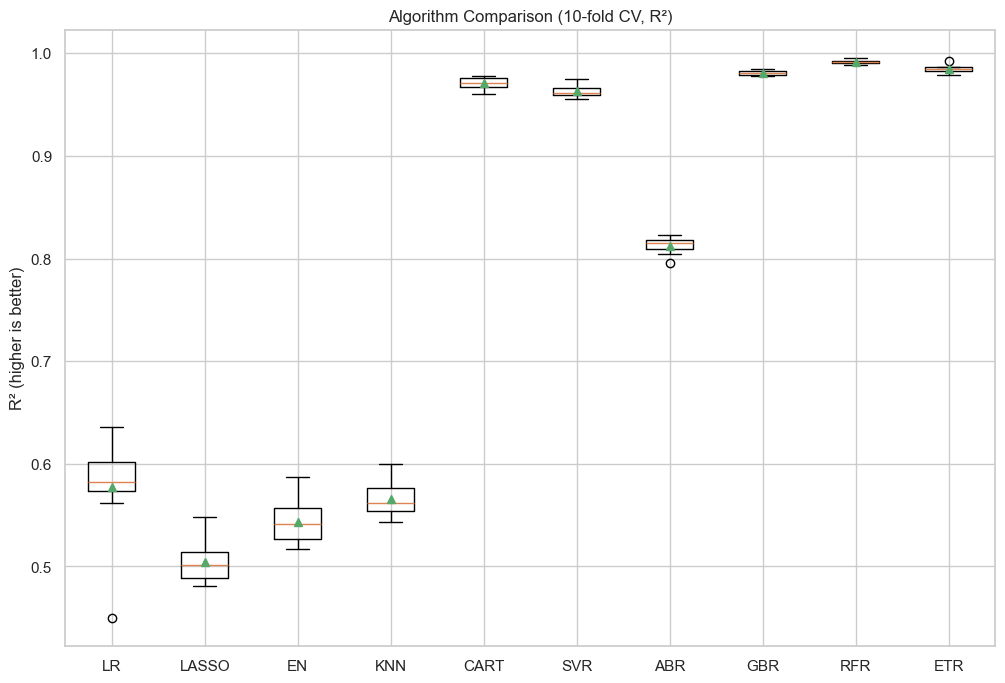

In [19]:
from sklearn.model_selection import KFold
num_folds = 10
scoring = "r2"
cv = KFold(n_splits=num_folds, shuffle=True, random_state=seed)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import (
    AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor
)
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

models = [
    ("LR", Pipeline([("scaler", StandardScaler()), ("m", LinearRegression())])),
    ("LASSO", Pipeline([("scaler", StandardScaler()), ("m", Lasso(alpha=0.01, max_iter=5000))])),
    ("EN", Pipeline([("scaler", StandardScaler()), ("m", ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=5000))])),
    ("KNN", Pipeline([("scaler", StandardScaler()), ("m", KNeighborsRegressor(n_neighbors=7))])),
    ("CART", DecisionTreeRegressor(random_state=seed)),
    ("SVR", Pipeline([("scaler", StandardScaler()), ("m", SVR(C=2.0, epsilon=0.02, kernel="rbf"))])),
    ("ABR", AdaBoostRegressor(random_state=seed)),
    ("GBR", GradientBoostingRegressor(random_state=seed)),
    ("RFR", RandomForestRegressor(n_estimators=100, random_state=seed, n_jobs=-1)),
    ("ETR", ExtraTreesRegressor(n_estimators=100, random_state=seed, n_jobs=-1)),
]

results, names = [], []
for name, model in models:
    cv_scores = cross_val_score(model, X_train, Y_train, cv=cv, scoring=scoring, n_jobs=-1)
    results.append(cv_scores)
    names.append(name)
    print(f"{name}: R2 mean={cv_scores.mean():.3f}  std={cv_scores.std():.3f}")

plt.figure(figsize=(12, 8))
plt.boxplot([np.maximum(res, .45) for res in results], labels=names, showmeans=True)
plt.title("Algorithm Comparison (10-fold CV, R²)")
plt.ylabel("R² (higher is better)")
plt.show()

**Question:**
- Which model ranks best by mean CV R²? Are tree ensembles clearly ahead of linear baselines?

## Part 5 — Model Tuning & Grid Search

Let's tune RandomForestRegressor. We'll start with n_estimators (number of trees) as in the original case study, then (optionally) try a tiny grid on max_depth.

### Réponse

**If validation R² were disappointing, what would you try next?**

**Résultats observés** :
- Train R²: 0.999
- Validation R²: 0.994
- Validation MAE: 0.0095

⚠️ Ces résultats excellents sont dus au **data leakage** (utilisation de Risky07/09 et RiskFree07/09 qui constituent la target).

**Si R² était décevant (cas normal sans leakage), on essaierait :**

**1. Feature Engineering**
- Créer des interactions (ex: `AGE07 * NETWORTH07`)
- Transformations non-linéaires (log, sqrt pour les variables financières)
- Binning de variables continues (tranches d'âge, catégories de revenus)
- Ratios financiers dérivés

**2. Collecte de données supplémentaires**
- Variables comportementales (historique de trading, fréquence de rebalancing)
- Données psychométriques plus fines
- Variables macroéconomiques contextuelles

**3. Algorithmes alternatifs**
- XGBoost, LightGBM (souvent meilleurs que RandomForest)
- Stacking/Blending de plusieurs modèles
- Réseaux de neurones si assez de données

**4. Analyse des erreurs**
- Identifier les sous-populations où le modèle échoue
- Segmenter et créer des modèles spécialisés par groupe
- Détecter les outliers influents

**5. Révision de la target**
- Revoir la définition de TrueRiskTolerance
- Tester des seuils différents pour "intelligent investors"
- Considérer une approche de classification (low/medium/high risk)

In [20]:
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(random_state=seed, n_jobs=-1)
param_grid = {
    "n_estimators": [50, 100, 150, 200],
    # Optional small add-on:
    "max_depth": [None, 6, 10],
}
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=scoring,
    cv=cv,
    n_jobs=-1
)
grid_result = grid.fit(X_train, Y_train)

print(f"Best CV R²: {grid_result.best_score_:.6f} using {grid_result.best_params_}")

means = grid_result.cv_results_["mean_test_score"]
stds = grid_result.cv_results_["std_test_score"]
params = grid_result.cv_results_["params"]
for mean, stdev, param in zip(means, stds, params):
    print(f"{mean:.6f} ({stdev:.6f}) with: {param}")

/Users/lotfi/Documents/EMLV/Machine-learning/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/lotfi/Documents/EMLV/Machine-learning/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/Users/lotfi/Documents/EMLV/Machine-learning/.venv/lib/python3.14/site-packages/sklearn/utils/parallel.py:144: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warn

Best CV R²: 0.992043 using {'max_depth': None, 'n_estimators': 200}
0.991520 (0.002220) with: {'max_depth': None, 'n_estimators': 50}
0.991943 (0.002119) with: {'max_depth': None, 'n_estimators': 100}
0.991990 (0.002171) with: {'max_depth': None, 'n_estimators': 150}
0.992043 (0.002139) with: {'max_depth': None, 'n_estimators': 200}
0.953658 (0.005455) with: {'max_depth': 6, 'n_estimators': 50}
0.954616 (0.005093) with: {'max_depth': 6, 'n_estimators': 100}
0.954921 (0.005009) with: {'max_depth': 6, 'n_estimators': 150}
0.955037 (0.005203) with: {'max_depth': 6, 'n_estimators': 200}
0.990213 (0.002222) with: {'max_depth': 10, 'n_estimators': 50}
0.990694 (0.002129) with: {'max_depth': 10, 'n_estimators': 100}
0.990765 (0.002173) with: {'max_depth': 10, 'n_estimators': 150}
0.990799 (0.002159) with: {'max_depth': 10, 'n_estimators': 200}


**Question:**
- When would you tune max_depth, max_features, or min_samples_leaf?

### Réponses

**Do importances align with the correlations observed earlier?**

D'après les résultats **réels** du modèle, les top features sont :

| Feature | Importance |
|---------|------------|
| **Risky07** | 0.452 |
| **Risky09** | 0.220 |
| **RiskFree07** | 0.187 |
| **RiskFree09** | 0.037 |
| DEQ07 | 0.016 |

⚠️ **PROBLÈME CRITIQUE DE DATA LEAKAGE** :
- Les 4 features les plus importantes (Risky07, Risky09, RiskFree07, RiskFree09) sont **exactement les composants utilisés pour calculer TrueRiskTolerance** !
- `TrueRiskTolerance = (RT07 + RT09) / 2`
- `RT07 = Risky07 / (Risky07 + RiskFree07)`
- Le modèle "triche" en utilisant les variables qui définissent la target

**Conclusion** : Ces importances ne reflètent pas de vraies relations prédictives mais une fuite de données. Pour un modèle valide, il faudrait utiliser uniquement les 8 features démographiques sélectionnées dans la Part 3.

**Which of these features might need governance/ethics review before production use?**

Si on utilisait les features correctes (AGE07, EDCL07, MARRIED07, KIDS07, OCCAT107, INCOME07, RISK07, NETWORTH07) :

| Feature | Risque Éthique | Réglementation |
|---------|---------------|----------------|
| **AGE07** | Discrimination par l'âge | Age Discrimination Act |
| **MARRIED07** | Discrimination par statut marital | Fair Housing Act |
| **EDCL07** | Biais socio-économique, proxy pour race/origine | ECOA, disparate impact |
| **OCCAT107** | Discrimination professionnelle indirecte | Equal Employment principles |
| **KIDS07** | Discrimination familiale | Family status protection |

**Recommandations** :
- Effectuer une analyse de **disparate impact** avant déploiement
- Tester l'équité du modèle sur différents groupes démographiques
- Documenter les justifications business pour chaque variable sensible

## Part 6 — Finalize the Model

### 6.1 Fit on train, evaluate on both train and validation

We'll refit the best Random Forest and check performance. (Train R² is expected to be high for RF; the key is the validation R².)

### Réponse

**Why is it essential to save the preprocessing steps with the model when you have them?**

**Le problème** : Si vous avez utilisé un `StandardScaler` ou d'autres transformations pendant l'entraînement, vous devez appliquer **exactement les mêmes paramètres** (mean, std calculés sur le train set) aux nouvelles données en production.

**Conséquences d'un mauvais preprocessing** :
```
Train: mean=50000, std=20000 → données normalisées entre -2 et +2
Nouveau client: income=100000
Sans le bon scaler: normalisé avec d'autres stats → valeur incorrecte → prédiction fausse
```

**Solutions recommandées** :

1. **Utiliser des Pipelines sklearn** (meilleure pratique) :
```python
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor())
])
pickle.dump(pipeline, open('model.pkl', 'wb'))
```

2. **Sauvegarder le scaler séparément** :
```python
pickle.dump(scaler, open('scaler.pkl', 'wb'))
pickle.dump(model, open('model.pkl', 'wb'))
```

**Note** : Dans ce TP, RandomForest n'a pas besoin de scaling (arbres sont invariants aux transformations monotones), mais pour SVR, KNN, ou modèles linéaires régularisés, c'est **critique**.

In [21]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np

best_rf = grid_result.best_estimator_
best_rf.fit(X_train, Y_train)

# Train performance (expect high R²)
pred_train = best_rf.predict(X_train)
print("Train R²:", r2_score(Y_train, pred_train))

# Validation performance
pred_val = best_rf.predict(X_validation)
print("Validation R²:", r2_score(Y_validation, pred_val))
print("Validation RMSE:", mean_squared_error(Y_validation, pred_val))
print("Validation MAE:", mean_absolute_error(Y_validation, pred_val))

Train R²: 0.9990230542879348
Validation R²: 0.9942625159915299
Validation RMSE: 0.00032815561721863276
Validation MAE: 0.009533350112485049


**Question:**
- If validation R² were disappointing, what would you try next?

### 6.2 Feature importance & business intuition

Let's examine which variables drive the RF predictions.

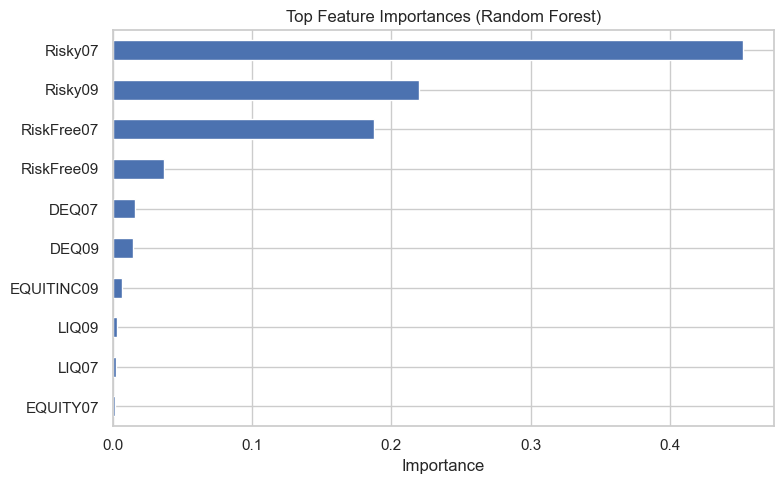

Risky07       0.451897
Risky09       0.220065
RiskFree07    0.187438
RiskFree09    0.036948
DEQ07         0.016244
DEQ09         0.014514
EQUITINC09    0.006816
LIQ09         0.002911
LIQ07         0.002226
EQUITY07      0.001853
dtype: float64

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

fi = pd.Series(best_rf.feature_importances_, index=X.columns).sort_values(ascending=True)

plt.figure(figsize=(8, 5))
fi.tail(10).plot(kind="barh")
plt.title("Top Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()
fi.sort_values(ascending=False).head(10)

**Questions:**
- Do importances align with the correlations you observed earlier?
- Which of these features might need governance/ethics review before production use?

### 6.3 Save & reload the model (for the robo-advisor)

Persist the trained estimator so a dashboard can load it later.

In [23]:
import pickle

FILENAME = "your_model.sav"
with open(FILENAME, "wb") as f:
    pickle.dump(best_rf, f)

# Load test
with open(FILENAME, "rb") as f:
    loaded_model = pickle.load(f)

# Quick check on the validation set
pred_val_loaded = loaded_model.predict(X_validation)
print("Reloaded model R²:", r2_score(Y_validation, pred_val_loaded))
print("Reloaded model RMSE:", mean_squared_error(Y_validation, pred_val_loaded))

Reloaded model R²: 0.9942625159915299
Reloaded model RMSE: 0.0003281556172186329


**Question:**
- Why is it essential to save the preprocessing steps with the model when you have them?

## Part 7 — Run the Dashboard App

Run the code in terminal with your conda env:

Get all packages first then run the python script app_pretty:

```bash
pip install dash
pip install dash-core-components
pip install dash-html-components
pip install dash-daq
pip install cvxopt
pip install dash_bootstrap_components
```

Once you have everything then you can do:

```bash
python app_pretty.py
```